In [17]:
import sys
sys.path.insert(0, "/home/bill/pymc3/")
import pymc3 as pm
import theano.tensor as tt

import matplotlib.pyplot as plt
plt.style.use('seaborn-notebook')
import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Times New Roman"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "serif"
%matplotlib inline

This is a series of examples which demonstrate some of the types of Gaussian process models that can be constructed in PyMC3.  

# Marginal GP (doing MAP = marginal posterior , not marg like)

- data $y$ modeled as the sum of a gp, $f$, and IID Gaussian noise

## Simulate Data

/home/bill/anaconda3/lib/python3.5/site-packages/scipy/stats/_multivariate.py:535: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


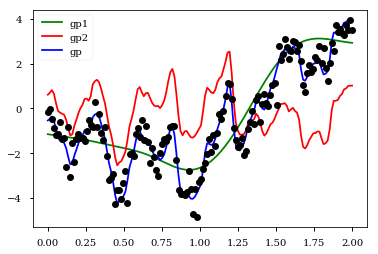

In [18]:
np.random.seed(10)

n = 150
X = np.linspace(0, 2, n)[:, None]

# gp1
ℓ1_true = 0.3
η1_true = 1.5
K1 = (tt.square(η1_true) * pm.gp.cov.ExpQuad(1, ℓ1_true)(X)).eval()
# gp1 mean func
coeffs_true = 2.0
intercept_true = -1.5
m1 = pm.gp.mean.Linear(coeffs=coeffs_true, intercept=intercept_true)(X).eval()
f1_true = pm.MvNormal.dist(mu=m1, cov=K1).random(size=1)

# gp2
ℓ2_true = 0.05
η2_true = 1.0
K2 = (tt.square(η2_true) * pm.gp.cov.Matern52(1, ℓ2_true)(X)).eval()
# gp2 mean_func
m2 = np.zeros(n)
f2_true = pm.MvNormal.dist(mu=m2, cov=K2).random(size=1)

#gp
f_true = f1_true + f2_true

# data observed with IID Gaussian noise
σ_true = 0.5
noise = pm.Normal.dist(mu=0.0, sd=σ_true).random(size=n)
y = f_true + noise
plt.plot(X, f1_true, "g", label="gp1");
plt.plot(X, f2_true, "r", label="gp2");
plt.plot(X, f_true, "b", label="gp");
plt.plot(X, y, 'ok');
plt.legend();

## Infer hyperparameters

In [ ]:
with pm.Model() as model:
    # gp1, long term trend
    ℓ1 = pm.Gamma("ℓ1", alpha=1, beta=1, testval=0.5)
    η1 = pm.HalfCauchy("η1", beta=3)
    cov1 = tt.square(η1) * pm.gp.cov.ExpQuad(1, ℓ1) 
   
    # gp1 mean function
    coeffs = pm.StudentT("coeffs", mu=0.0, lam=0.1, nu=4)
    intercept = pm.StudentT("intercept", mu=0.0, lam=0.1, nu=4)
    mean = pm.gp.mean.Linear(coeffs, intercept)
    
    # gp1
    gp1 = pm.gp.Marginal(mean_func=mean, cov_func=cov1)
   
    #gp2, shorter variation
    ℓ2 = pm.Gamma("ℓ2", alpha=1, beta=1, testval=0.1)
    η2 = pm.HalfCauchy("η2", beta=3)
    cov2 = tt.square(η2) * pm.gp.cov.Matern52(1, ℓ2)
    gp2 = pm.gp.Marginal(cov_func=cov2)
    
    # additive
    gp = gp1 + gp2
    
    σ = pm.HalfCauchy("σ", beta=3, testval=0.1)
    y_ = gp.prior("y", X=X, y=y, noise=σ)
    start = pm.find_MAP(method="L-BFGS-B")
    #tr = pm.sample(1000, init='map')

## Predict

In [4]:
ns = 400
Xnew = np.linspace(0.0, 7.0, ns)[:, None]
with model:
    f_pred = gp.conditional("f_pred", n_points=ns, Xnew=Xnew)

In [5]:
with model:
    f1_pred = gp1.conditional("f1_pred", n_points=ns, Xnew=Xnew, X=X, y=y, noise=σ)
    f2_pred = gp2.conditional("f2_pred", n_points=ns, Xnew=Xnew, X=X, y=y, noise=σ)

In [6]:
with model:
    samples = pm.sample_ppc([start], vars=[f_pred, f1_pred, f2_pred], samples=100)

100%|██████████| 100/100 [00:12<00:00, 11.46it/s]


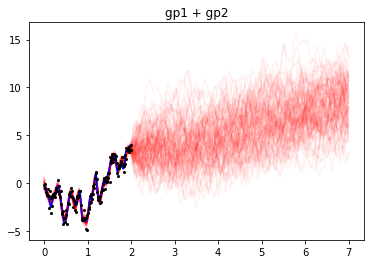

In [7]:
plt.plot(Xnew.flatten(), samples[f_pred.name].T, "r", alpha=0.05);
plt.plot(X, f_true, 'b');
plt.plot(X, y, 'ko', markersize=2);
plt.title("gp1 + gp2");

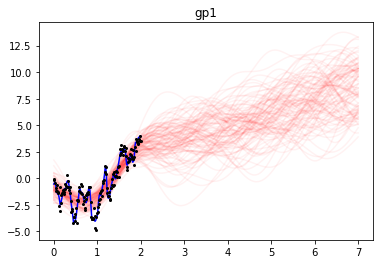

In [8]:
plt.plot(Xnew.flatten(), samples[f1_pred.name].T, "r", alpha=0.05);
plt.plot(X, f_true, 'b');
plt.plot(X, y, 'ko', markersize=2);
plt.title("gp1");

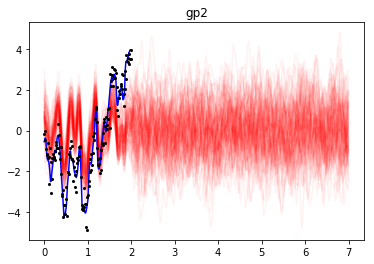

In [9]:
plt.plot(Xnew.flatten(), samples[f2_pred.name].T, "r", alpha=0.05);
plt.plot(X, f_true, 'b');
plt.plot(X, y, 'ko', markersize=2);
plt.title("gp2");

# Latent GP

- model $f$ explicitly
- simulate data as a classification problem

## Simulate Data

/home/bill/anaconda3/lib/python3.5/site-packages/scipy/stats/_multivariate.py:535: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


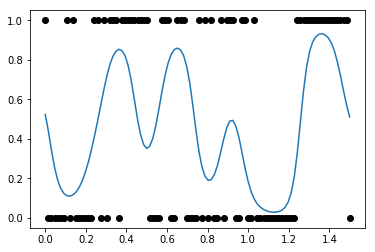

In [7]:
np.random.seed(12)

n = 100
ℓ_true = 0.1
σ_true = 0.2
η_true = 1.0

X = np.linspace(0, 1.5, n)[:, None]
Kx = (tt.square(η_true) * pm.gp.cov.ExpQuad(1, ℓ_true)(X)).eval()
m = np.zeros(n)

nu = 2
f_true = pm.MvStudentT.dist(nu=nu, mu=m, cov=Kx).random(size=1)

def invlogit(x, eps=sys.float_info.epsilon):
    return (1.0 + 2.0 * eps) / (1.0 + np.exp(-x)) + eps

y = pm.Bernoulli.dist(p=invlogit(f_true)).random()
plt.plot(X, invlogit(f_true));
plt.plot(X, y, 'ok');

In [8]:
with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=1, beta=1, testval=0.4)
    η = pm.HalfCauchy("η", beta=3)
    cov = tt.square(η) * pm.gp.cov.ExpQuad(1, ℓ) 
    mean = pm.gp.mean.Zero()
    
    nu = pm.Gamma("nu", alpha=2, beta=0.1)
    gp = pm.gp.TP(mean_func=mean, cov_func=cov, nu=nu)
    
    f = gp.prior("f", n_points=n, X=X, nu=nu)
    p = pm.Deterministic("p", pm.math.invlogit(f))
    y_ = pm.Bernoulli("y", p=p, observed=y)
    
    tr = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 72.806:   5%|▍         | 9397/200000 [00:41<13:30, 235.24it/s]
Convergence archived at 9400
Interrupted at 9,400 [4%]: Average Loss = 76.929
100%|██████████| 1500/1500 [03:38<00:00,  7.89it/s]


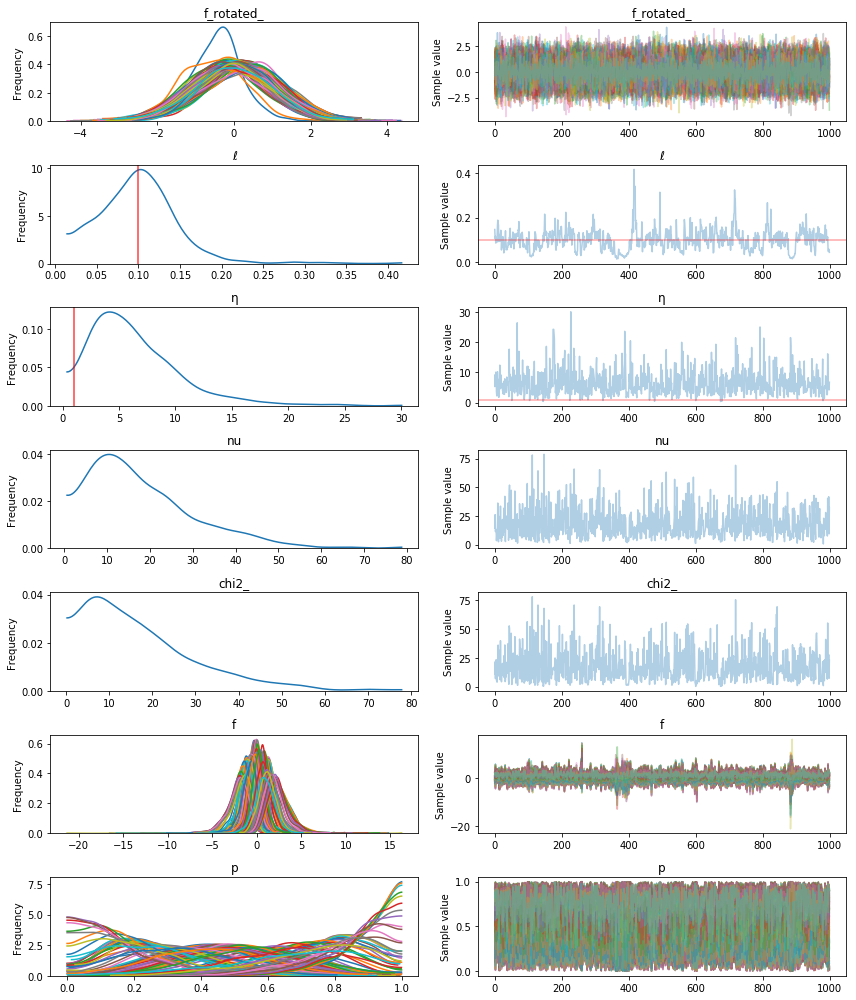

In [9]:
pm.traceplot(tr, lines={"ℓ": ℓ_true, "η": η_true, "σ": σ_true });

## Predict

In [12]:
n_pred = 200
Xnew = np.linspace(0.0, 1.5, n_pred)[:, None]
with model:
    f_pred = gp.conditional("f_pred1", n_pred, Xnew)
    samples = pm.sample_ppc(tr, vars=[f_pred], samples=100)

100%|██████████| 100/100 [00:05<00:00, 23.52it/s]


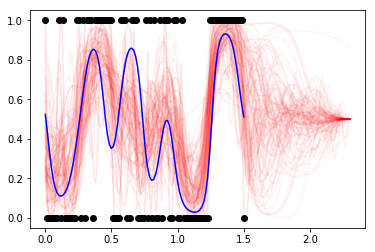

In [13]:
plt.plot(Xnew.flatten(), invlogit(samples[f_pred.name].T), "r", alpha=0.05);
plt.plot(X, invlogit(f_true), 'b');
plt.plot(X, y, 'ko');

# Additive latent

/home/bill/anaconda3/lib/python3.5/site-packages/scipy/stats/_multivariate.py:535: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
/home/bill/anaconda3/lib/python3.5/site-packages/scipy/stats/_multivariate.py:535: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


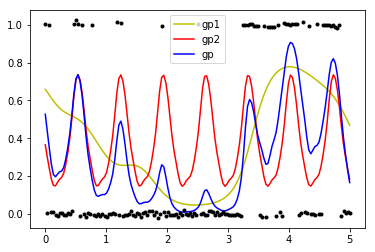

In [15]:
np.random.seed(10)

n = 150
X = np.linspace(0, 5, n)[:, None]

# gp1
η1_true = 1.5
ℓ1_true = 0.5
K1 = (tt.square(η1_true) * pm.gp.cov.ExpQuad(1, ℓ1_true)(X)).eval()
# gp1 mean func
m1 = np.zeros(n)
f1_true = pm.MvNormal.dist(mu=m1, cov=K1).random(size=1)

# gp2
η2_true = 1.5
ℓ2_true = 0.6
ℓp_true = 0.7
K2 = (tt.square(η2_true) * pm.gp.cov.Periodic(1, ℓ2_true, ℓp_true)(X)).eval()
# gp2 mean_func
m2 = np.zeros(n)
f2_true = pm.MvNormal.dist(mu=m2, cov=K2).random(size=1)

#gp
f_true = f1_true + f2_true

def invlogit(x, eps=sys.float_info.epsilon):
    return (1.0 + 2.0 * eps) / (1.0 + np.exp(-x)) + eps

y = pm.Bernoulli.dist(p=invlogit(f_true)).random()

plt.plot(X, invlogit(f1_true), "y", label="gp1");
plt.plot(X, invlogit(f2_true), "g", label="gp2");
plt.plot(X, invlogit(f_true), "slategrey", label="gp");
jitter = np.random.randn(n)*0.02
plt.plot(X, y+jitter, 'ok', ms=2);
plt.legend();


In [16]:
with pm.Model() as model:
    ℓ1 = pm.Gamma("ℓ1", alpha=1, beta=1, testval=0.5)
    η1 = pm.HalfCauchy("η1", beta=3)
    cov1 = tt.square(η1) * pm.gp.cov.ExpQuad(1, ℓ1) 
    gp1 = pm.gp.Latent(cov_func=cov1)
    
    ℓ2 = pm.Gamma("ℓ2", alpha=1, beta=1, testval=0.5)
    ℓp = pm.Gamma("ℓp", alpha=1, beta=1, testval=1.0)
    η2 = pm.HalfCauchy("η2", beta=3)
    cov2 = tt.square(η2) * pm.gp.cov.Periodic(1, ℓ2, ℓp) 
    gp2 = pm.gp.Latent(cov_func=cov2)
    
    gp = gp1 + gp2
    
    f = gp.prior("f", n_points=n, X=X)
    p = pm.Deterministic("p", pm.math.invlogit(f))
    y_ = pm.Bernoulli("y", p=p, observed=y)
    
    tr = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 95.669:   7%|▋         | 13191/200000 [01:49<29:18, 106.23it/s]
Convergence archived at 13200
Interrupted at 13,200 [6%]: Average Loss = 121.53
100%|██████████| 1500/1500 [15:34<00:00,  3.97it/s] /home/bill/pymc3/pymc3/step_methods/hmc/nuts.py:463: UserWarning: Chain 0 contains 2 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))



In [23]:
ns = 200
Xnew = np.linspace(-0.1, 7, ns)[:, None]
with model:
    f_pred = gp.conditional("f_pred1", ns, Xnew)

In [24]:
with model:
    f1_pred = gp1.conditional("f1_pred1", ns, Xnew, X=X, f=f)

In [25]:
with model:
    samples = pm.sample_ppc(tr, vars=[f_pred, f1_pred], samples=100)

100%|██████████| 100/100 [00:05<00:00, 18.20it/s]


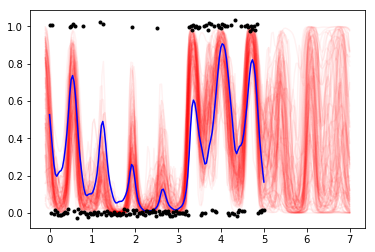

In [26]:
plt.plot(Xnew.flatten(), invlogit(samples[f_pred.name].T), "r", alpha=0.05);
plt.plot(X, invlogit(f_true), 'b');
jitter = np.random.randn(n)*0.01
plt.plot(X, y+jitter, 'ok', ms=3);

In [ ]:
plt.plot(Xnew.flatten(), invlogit(samples[f1_pred.name].T), "g", alpha=0.05);
plt.plot(X, p_true, 'b');
plt.plot(X, invlogit(f1_true), 'y');
jitter = np.random.randn(n)*0.01
plt.plot(X, y+jitter, 'ok', ms=3);

## Infer hyperparameters

# Marginal GP with sparse approximation

- data $y$ modeled as the sum of a gp, $f$, and IID Gaussian noise
- FITC approximation used with 20 inducing points

## Simulate Data

In [ ]:
np.random.seed(30)

n = 500
ℓ_true = 0.1
σ_true = 0.5
η_true = 1.5

X = np.linspace(0, 1, n)[:, None]
Kx = (tt.square(η_true) * pm.gp.cov.ExpQuad(1, ℓ_true)(X)).eval()
m = np.zeros(n)

f_true = pm.MvNormal.dist(mu=m, cov=Kx).random(size=1)
noise = pm.Normal.dist(mu=0.0, sd=σ_true).random(size=n)
y = f_true + noise

nu = 20
Xu = np.linspace(0, 1, nu)[:, None]

plt.plot(X, y, 'ok', ms=2);
plt.plot(X, f_true, "blue", lw=2);
plt.plot(Xu, np.zeros(nu), "rx");

## Infer hyperparameters

In [ ]:
with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=1, beta=1, testval=0.4)
    η = pm.HalfCauchy("η", beta=3)
    cov = tt.square(η) * pm.gp.cov.ExpQuad(1, ℓ) 
    mean = pm.gp.mean.Zero()
    σ = pm.HalfCauchy("σ", beta=3)
    
    gp = pm.gp.MarginalSparse(cov_func=cov, approx="VFE")
    y_ = gp.prior("y", X, Xu, y, σ)
    #tr = pm.sample(1000)
    mp = pm.find_MAP(method="L-BFGS-B")

In [ ]:
#pm.traceplot(tr, lines={"ℓ": ℓ_true, "η": η_true, "σ": σ_true });

## Predict

In [ ]:
ns = 200
Xnew = np.linspace(-0.05, 1.05, ns)[:, None]
with model:
    f_pred = gp.conditional("f_pred", ns, Xnew)

In [ ]:
with model:
    samples = pm.sample_ppc([mp], vars=[f_pred], samples=100)

plt.plot(X, y, 'ko');
plt.plot(X, f_true, 'b');
plt.plot(Xnew.flatten(), samples[f_pred.name].T, "r", alpha=0.05);